In [8]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications
from keras import callbacks

In [9]:
!git clone https://github.com/emeaal/book-dataset.git

ödesdigert: destinationssökvägen "book-dataset" finns redan och är inte en tom katalog.


In [10]:
train = list(os.walk('book-dataset/book_covers/book-covers'))

In [11]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'Art-Photography': 0, 'Biography': 1, 'Business-Finance-Law': 2, 'Childrens-Books': 3, 'Computing': 4, 'Crafts-Hobbies': 5, 'Crime-Thriller': 6, 'Dictionaries-Languages': 7, 'Entertainment': 8, 'Food-Drink': 9, 'Graphic-Novels-Anime-Manga': 10, 'Health': 11, 'History-Archaeology': 12, 'Home-Garden': 13, 'Humour': 14, 'Medical': 15, 'Mind-Body-Spirit': 16, 'Natural-History': 17, 'Personal-Development': 18, 'Poetry-Drama': 19, 'Reference': 20, 'Religion': 21, 'Romance': 22, 'Science-Fiction-Fantasy-Horror': 23, 'Science-Geography': 24, 'Society-Social-Sciences': 25, 'Sport': 26, 'Stationery': 27, 'Teaching-Resources-Education': 28, 'Technology-Engineering': 29, 'Teen-Young-Adult': 30, 'Transport': 31, 'Travel-Holiday-Guides': 32}


In [12]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] 
        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)
            image = cv2.imread(path_of_file)
            if(image is not None):
                cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                if len(image.shape) == 1:
                    image = np.expand_dims(image, axis=0)
                images.append(image)
                labels.append(value_of_label)
    print(f'Number of images: {len(images)}, Number of labels: {len(labels)}')
    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)
    return images, labels

images, labels = dataset('book-dataset/book_covers/book-covers')
images, labels = shuffle(images, labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


Number of images: 32581, Number of labels: 32581


In [13]:
print(type(images))
images.shape

<class 'numpy.ndarray'>


(32581, 224, 224, 3)

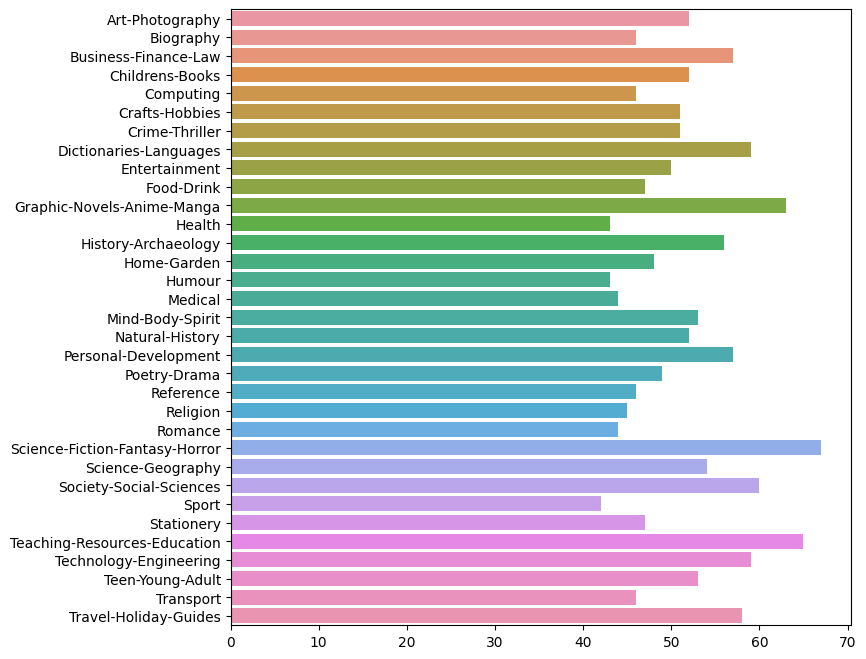

In [14]:
covers = train[0][1]
nr_of_categories = []
for _ in range(1, 34):
    nr_of_categories.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = covers, x = nr_of_categories);

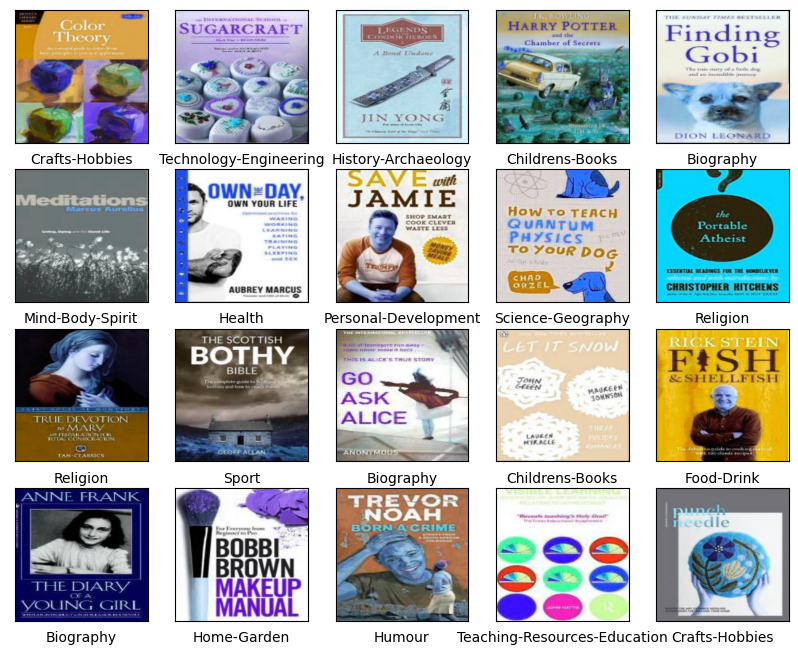

In [15]:
plt.figure(figsize = (10,10))
for _ in range(20):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

In [16]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.1)

In [17]:
train_ds = train_datagen.flow_from_directory('book-dataset/book_covers/book-covers',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('book-dataset/book_covers/book-covers',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 29346 images belonging to 33 classes.
Found 3235 images belonging to 33 classes.


In [18]:
train_ds.class_indices

{'Art-Photography': 0,
 'Biography': 1,
 'Business-Finance-Law': 2,
 'Childrens-Books': 3,
 'Computing': 4,
 'Crafts-Hobbies': 5,
 'Crime-Thriller': 6,
 'Dictionaries-Languages': 7,
 'Entertainment': 8,
 'Food-Drink': 9,
 'Graphic-Novels-Anime-Manga': 10,
 'Health': 11,
 'History-Archaeology': 12,
 'Home-Garden': 13,
 'Humour': 14,
 'Medical': 15,
 'Mind-Body-Spirit': 16,
 'Natural-History': 17,
 'Personal-Development': 18,
 'Poetry-Drama': 19,
 'Reference': 20,
 'Religion': 21,
 'Romance': 22,
 'Science-Fiction-Fantasy-Horror': 23,
 'Science-Geography': 24,
 'Society-Social-Sciences': 25,
 'Sport': 26,
 'Stationery': 27,
 'Teaching-Resources-Education': 28,
 'Technology-Engineering': 29,
 'Teen-Young-Adult': 30,
 'Transport': 31,
 'Travel-Holiday-Guides': 32}

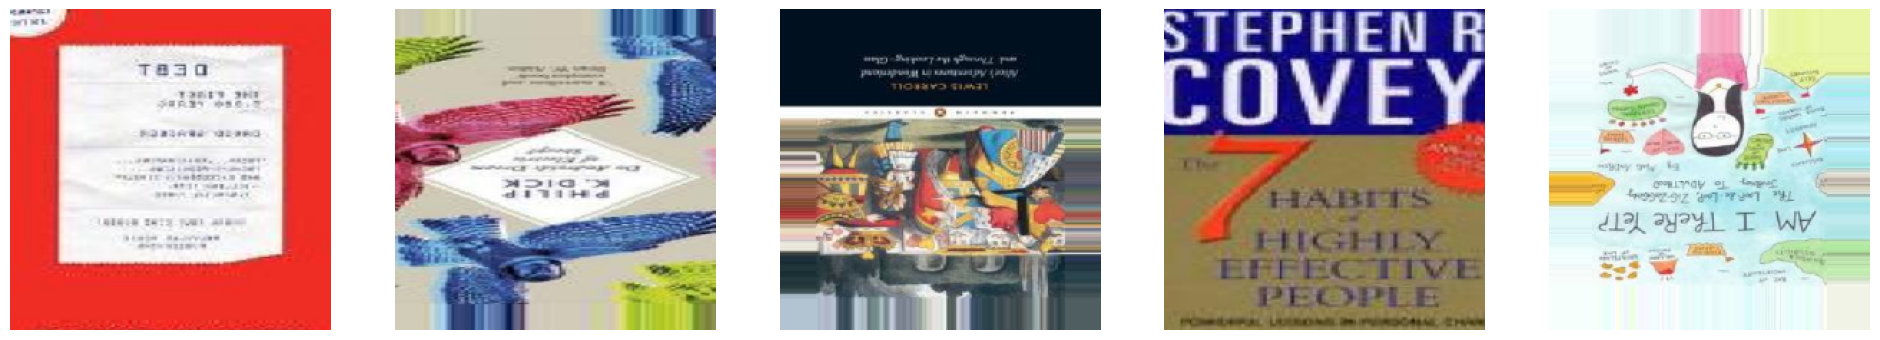

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,24))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

In [20]:
from keras import applications
res_base = applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = res_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(33, activation = 'softmax')(x)
res_model = Model(inputs, outputs)
res_model.summary
print(res_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 33)                33825     
                                                           

In [21]:
res_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [22]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = res_model.fit(train_ds, batch_size = 32, 
                    epochs = 25, validation_data =(val_ds), 
                    callbacks =[earlystopping])

Epoch 1/25


/home/gusaaltoem@GU.GU.SE/.local/lib/python3.10/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-01-23 11:33:09.825934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8202
2023-01-23 11:33:11.168380: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55f8209535c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-23 11:33:11.168428: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-01-23 11:33:11.168439: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-01-23 11:33:11.168446: I tensorflow/compiler/xla/service/s

459/459 [==============================] - 403s 864ms/step - loss: 3.5173 - categorical_accuracy: 0.0308 - val_loss: 3.4932 - val_categorical_accuracy: 0.0362
Epoch 2/25
459/459 [==============================] - 394s 859ms/step - loss: 3.4926 - categorical_accuracy: 0.0345 - val_loss: 3.4876 - val_categorical_accuracy: 0.0374
Epoch 3/25
459/459 [==============================] - 395s 860ms/step - loss: 3.4865 - categorical_accuracy: 0.0399 - val_loss: 3.4779 - val_categorical_accuracy: 0.0433
Epoch 4/25
459/459 [==============================] - 395s 860ms/step - loss: 3.4822 - categorical_accuracy: 0.0415 - val_loss: 3.4730 - val_categorical_accuracy: 0.0498
Epoch 5/25
459/459 [==============================] - 396s 862ms/step - loss: 3.4738 - categorical_accuracy: 0.0458 - val_loss: 3.4661 - val_categorical_accuracy: 0.0491
Epoch 6/25
459/459 [==============================] - 396s 862ms/step - loss: 3.4665 - categorical_accuracy: 0.0466 - val_loss: 3.4634 - val_categorical_accuracy

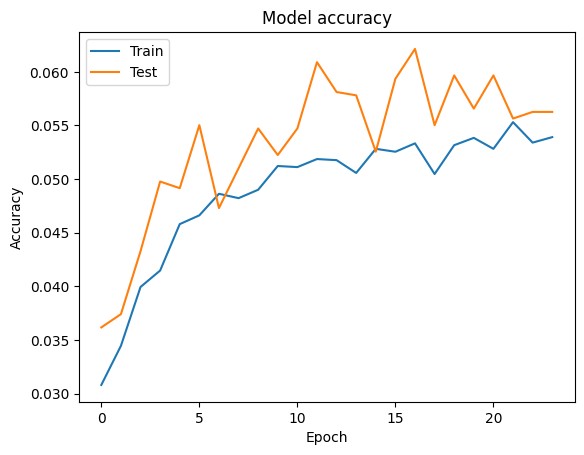

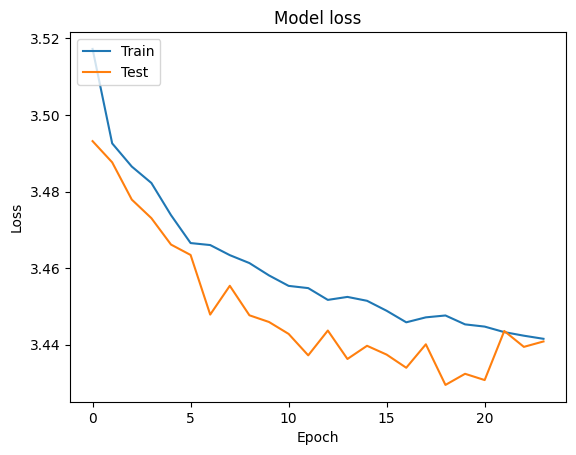

In [23]:
#epochs = 1
#res_model.fit(train_ds, epochs=epochs, validation_data=val_ds)
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
res_model.save('res.model_03')

INFO:tensorflow:Assets written to: res.model_03/assets


INFO:tensorflow:Assets written to: res.model_03/assets


In [25]:
res_model.evaluate(train_ds)

459/459 [==============================] - 357s 776ms/step - loss: 3.4156 - categorical_accuracy: 0.0679


[3.415647506713867, 0.06791385263204575]

In [99]:
from keras import applications
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

In [100]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(33, activation = 'softmax')(x)
vgg_model = Model(inputs, outputs)
vgg_model.summary
print(vgg_model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 33)                33825     
                                                           

In [101]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [104]:
earlystopping2 = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history2 = vgg_model.fit(train_ds, batch_size = 32, 
                    epochs = 25, validation_data =(val_ds), 
                    callbacks =[earlystopping])

Epoch 1/25
459/459 [==============================] - 395s 861ms/step - loss: 3.2470 - categorical_accuracy: 0.1133 - val_loss: 3.2034 - val_categorical_accuracy: 0.1301
Epoch 2/25
459/459 [==============================] - 394s 858ms/step - loss: 3.1799 - categorical_accuracy: 0.1317 - val_loss: 3.1644 - val_categorical_accuracy: 0.1413
Epoch 3/25
459/459 [==============================] - 391s 851ms/step - loss: 3.1410 - categorical_accuracy: 0.1418 - val_loss: 3.1531 - val_categorical_accuracy: 0.1419
Epoch 4/25
459/459 [==============================] - 391s 852ms/step - loss: 3.1184 - categorical_accuracy: 0.1489 - val_loss: 3.1275 - val_categorical_accuracy: 0.1509
Epoch 5/25
459/459 [==============================] - 395s 861ms/step - loss: 3.1020 - categorical_accuracy: 0.1516 - val_loss: 3.1202 - val_categorical_accuracy: 0.1468
Epoch 6/25
459/459 [==============================] - 393s 856ms/step - loss: 3.0869 - categorical_accuracy: 0.1585 - val_loss: 3.1155 - val_categoric

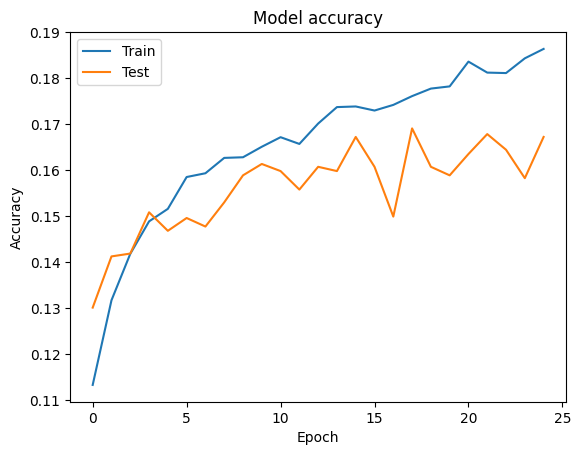

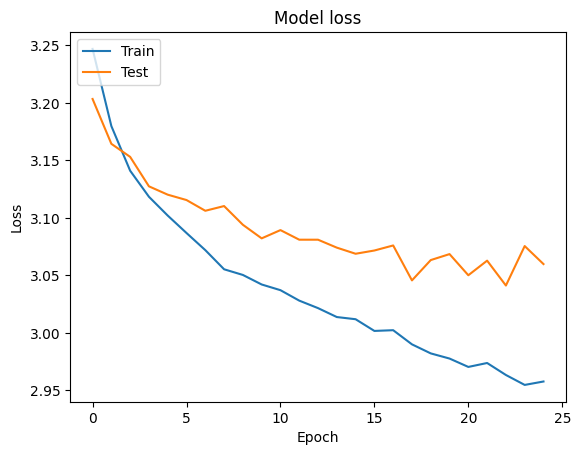

In [105]:
# Plot training & validation accuracy values
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
vgg_model.save('vgg.model_03')

In [28]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

1/1 [==============================] - 0s 35ms/step
The given image is of 
Class: 9 
Species: Food-Drink


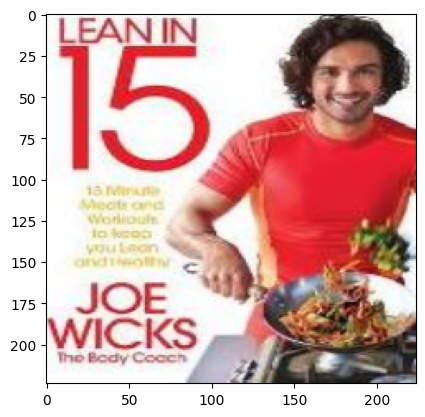

In [111]:
predictor('book-dataset/book_covers/book-covers/Food-Drink/0000011.jpg', vgg_model)

1/1 [==============================] - 0s 33ms/step
The given image is of 
Class: 15 
Species: Medical


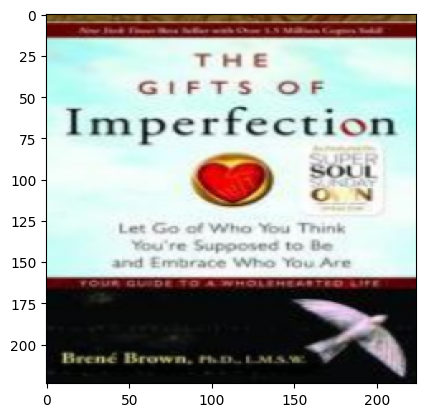

In [109]:
predictor('book-dataset/book_covers/book-covers/Personal-Development/0000010.jpg', vgg_model)

1/1 [==============================] - 0s 41ms/step
The given image is of 
Class: 31 
Species: Transport


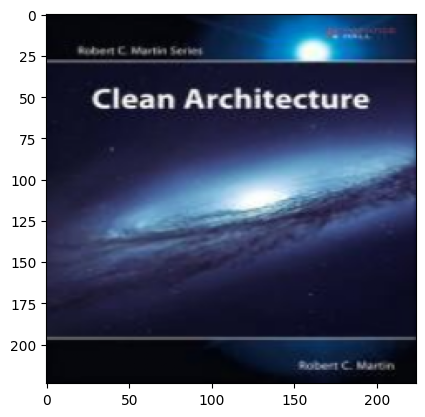

In [33]:
predictor('book-dataset/book_covers/book-covers/Computing/0000016.jpg', res_model)